---
layout: default
title: "Deep Learning - Speed up learning - Other optimization techinques"
categories: deeplearning
permalink: /ML30/
order: 30
comments: true
---

In [2]:
%pylab --no-import-all inline
from plot_ann import ann
import pandas as pd
from scipy.stats import multivariate_normal

Populating the interactive namespace from numpy and matplotlib


/home/marnec/.local/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# More sophisticated optimization techniques
There are other more sophisticated optimization techniques than gradient descent, in order to talk about them let's introduce **exponentially weighted averages**

## Exponentially weighted averages
Let's take the average daily temperature in London across the year 2019 (<a href="#fig:londtemp">figure below</a>)

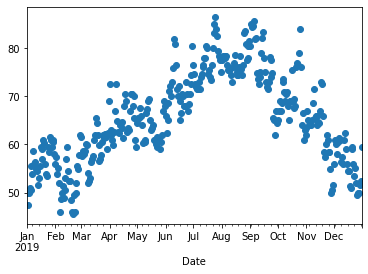

In [3]:
df = pd.read_csv('data/temps.csv', index_col=[0], parse_dates=[0], usecols=[1, 2, 3])\
.loc['2019']\
.mean(axis=1)\
.dropna()
df.plot(ls='none', marker='o');

<i id="fig:londtemp">Average daily temperatures in the year 2019 in London</i>

The data looks noisy and in order to compute the trend of the temperature across the year we can use the following approach. Starting from the first day $v_0=0$ we can proceed by averaging:

$$
\begin{aligned}
&v_0=0\\
&v_1 = 0.9v_0 + 0.1 \theta_1 \\
&v_2 = 0.9v_1 + 0.1 \theta_2 \\
&v_3 = 0.9v_3 + 0.1 \theta_3 \\
& \vdots \\
&v_t = 0.9v_{\tau-1} + 0.1 \theta_\tau \\
\end{aligned}
$$

where $\theta_i$ is current temperature and $\tau$ is the current day.

Let's rewrite the generalization as:

$$
\begin{equation}
v_t = \beta v_{\tau-1} + (1-\beta) \theta_\tau
\end{equation}
\label{eq:ewa} \tag{1}
$$

We can think of $v_t$ as approximately averaging over $\frac{1}{1-\beta}$ days, so when using:

* $\beta = 0.9 \to \frac{1}{1-0.9} \approx$ average 10 over days
* $\beta = 0.98 \to \frac{1}{1-0.98} \approx$ average over 50 days
* $\beta = 0.5 \to \frac{1}{1-5} \approx$ average over 2 days

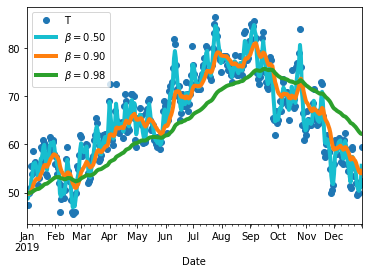

In [4]:
ax = plt.gca()
df.plot(ls='none', marker='o', ax=ax, label='T')
df.ewm(alpha=.5, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.50$', c='C9')
df.ewm(alpha=.1, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.90$')
df.ewm(alpha=.02, adjust=False).mean().plot(ax=ax, lw=4, label=r'$\beta=0.98$')

ax.legend();

<i id="fig:ewa">Exponentially weighted average applied to raw data with different values of $\beta$</i>

As we can see in <a href="#fig:ewa">the figure above</a>, increasing values of $\beta$ will produce smoother trends but on the flipside, we can notice that the smoothest trend is also shifted towards the right, since the rolling windows (the number of days on which each point is averaged on) is bigger and adapts more slowly to how the temperature changes. In fact, by setting a large $\beta$, we are giving a greater weight to the temperatures that have come before ($v_\tau$) and a smaller weight to the current temperature.

The equation in $\eqref{eq:ewa}$ is how you implement an **exponentially weighted moving average** or exponentially weighted average for short. The reason why they are called exponentially weighted averages become clear if we look at how $v_n$ is computed, let's take $v_{100}$:

$$
\begin{split}
& v_{100} = 0.1 \theta_{100} + 0.9 & v_{99} & \\
&& \shortparallel \\ &
&  0.1 \theta_{99} + 0.9 & v_{98} &\\
&&& \shortparallel \\
&&&  0.1 \theta_{98} + 0.9 & v_{97} \\
\end{split}
$$

And by expanding the algebra we can see that

$$
v_{100} = 0.1 \cdot 0.9 \theta_{99} + 0.1 \cdot (0.9)^2 \theta_{98} + 0.1 \cdot (0.9)^3 \theta_{97} + 0.1 \cdot (0.9)^4 \theta_{96} \dots
$$

So this is a weighted sum of $\theta$s where the weight of $\theta$ increases exponentially with the steps back from the current $\theta$. We can visualize that in the <a href="fig:ew">figure below</a>

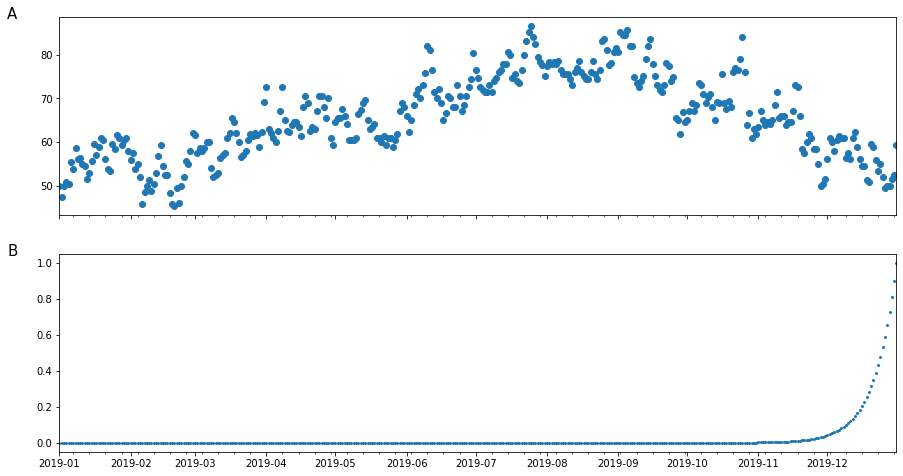

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex='col')
df.plot(ax=axes[0], ls='none', marker='o')
axes[1].plot(df.index, np.full_like(df, 0.9)**np.arange(len(df))[::-1], marker='o', markersize=2, ls='none')
for ax, l in zip(axes, 'AB'):
    ax.text(-0.05, 1.05, l, transform=ax.transAxes,
      fontsize=15, va='top', ha='right')

<i id="fig:ew">Exponential weights (B) applied to each data point (A) in the exponentially weighted average algorithm</i>

In order to say that $\beta = 0.9$ corresponds to averaging over around 10 days we observe that $0.9^{10} \approx 0.35 \approx \frac{1}{e}$, and more in general we have $(1 - \epsilon)^{\frac{1}{\epsilon}} = \frac{1}{e}$ (where $\epsilon = 1-\beta$).

All the terms $(1-\beta) \cdot \beta^x \approx 1$ up to a detail called bias correction. Especially around the first values of $v$, the approximation will be greatly underestimating the data since it cannot base on the full size of the window.

In order to reduce that error we use a corrected version of $v_\tau$

$$
\frac{v_\tau}{1-\beta^\tau}
$$

where $\tau$ is the current day

## Gradient descent with momentum
Gradient descent with momentum (aka just momentum) works almost always faster than regular gradient descent. The basic idea of momentum is to compute the exponentially weighted average of your gradients to update the weights.

Consider <a href="#fig:momentum">the figure below</a>: we can intuitively understand that larger steps in the $y$ direction will slow down learning, while larger steps in the $x$ direction will speed up learning.  

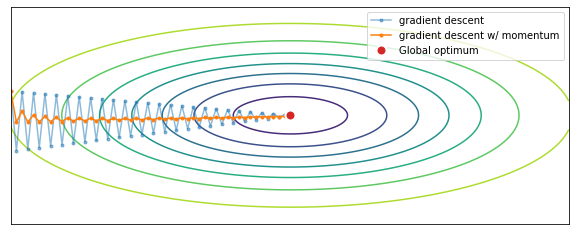

In [6]:
fig, ax = plt.subplots(figsize=(10, 4))
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1, .05], [0, .7]])
ax.contour(x, y, -rv.pdf(pos))

x = np.linspace(-2, 0)
y = np.zeros(50)
y[::2] = 1
y = (np.sin(y)-.5)*(np.arange(1, 100)[::-2]/75)
sy = pd.Series(y).ewm(alpha=.1).mean().values

ax.set_xticks([])
ax.set_yticks([])
ax.plot(x, y, marker='o', markersize=3, alpha=.5, label='gradient descent')
# ax.quiver(x[:-1], y[:-1], np.diff(x)+.05, np.diff(y), headwidth=3, headlength=4, width=0.002, scale=10)
ax.plot(x, sy, label='gradient descent w/ momentum', marker='o', markersize=3)
ax.plot([0], [0], marker='o', c='C3', ls='none', label='Global optimum', markersize=10, markeredgewidth=2, markeredgecolor='w')
ax.legend();

<i id="fig:momentum">Gradient descent steps across the feature space for normal gradient descent (blue) and gradient descent with momentum (B)</i>

When implementing momentum, on each iteration $t$, you compute the gradients $dw, db$ on the batch (or mini-batch) and then the exponentially weighted average of the gradients:

$$
\begin{split}
 v_{dw} & = \beta v_{dw} + (1-\beta)dw \\
 v_{db} & = \beta v_{db} + (1-\beta)db \\
\end{split}
$$

and consequently update the parameters matrix $w$ with $v_{dw}$

$$
\begin{split}
w & := w - \alpha v_{dw}\\
b & := b - \alpha v_{db}\\
\end{split}
$$

The effect of this is to smooth out the direction of your gradient descent. Usually bias correction is not necessary. This algorithm requires setting two hyperparameters: $\beta$ and $\alpha$. Normally $\beta$ is set to 0.9 which is a value that generally works well and $\alpha$ is left to be tuned.

##  RMSprop
Root mean square prop is another algorithm that will speed up learning. To illustrate how RMSprop works let's consider the feature space in <a href="#fig:momentum">the figure above</a>, where we set the $x$ axis as $w$ and the $y$ axis as $b$ (but they could also be $w_1, w_2$)

In RMSprop, for each iteration $t$ we will compute $s_{dw}$, that are the exponentially weighted average **of the square** of the derivatives.

$$
\begin{split}
 s_{dw} & = \beta s_{dw} + (1-\beta)dw^2 \\
 s_{db} & = \beta s_{db} + (1-\beta)db^2 \\
\end{split}
$$

and the parameters update is also slightly different from momentum

$$
\begin{split}
w & := w - \alpha \frac{dw}{\sqrt{s_{dw}}+\epsilon}\\
b & := b - \alpha \frac{db}{\sqrt{s_{db}}+\epsilon}\\
\end{split}
$$

Where $\epsilon=10^{-8}$ is added for numerical stability.

In order for RMSprop to work we hope that $db$ is large and $dw$ is small, and in fact if we look at <a href="#fig:momentum">the figure above</a> we can see that the derivatives of the standard gradient descent are much larger in the vertical direction than in the horizontal direction.

This algorithm requires setting two hyperparameters: $\beta$ and $\alpha$. Normally $\beta$ is set to 0.9 which is a value that generally works well and $\alpha$ is left to be tuned.

## Adam optimization
Among the many optimization algorithms proposed by the machine learning researcher community, the **ADAM** (ADAptive Moment estimation) optimization algorithm is one of the few that works well in a wide range of deep learning applications. The ADAM optimization algorithm combines RMSprop and momentum.

In ADAM optimization, for each iteration $t$ we will compute both $v_{dw}$ and $s_{dw}$ and combine them at update time:

$$
\begin{split}
& v_{dw} & = \beta_1 v_{dw} + (1-\beta_1)dw \\
& v_{db} & = \beta_1 v_{db} + (1-\beta_1)db \\
& s_{dw} & = \beta_2 s_{dw} + (1-\beta_2)dw^2 \\
& s_{db} & = \beta_2 s_{db} + (1-\beta_2)db^2 \\
\end{split}
$$

Correction is applied

$$
\begin{split}
& v_{dw} & = \frac{v_{dw}}{1-\beta_1^\tau}\\
& v_{db} & = \frac{v_{db}}{1-\beta_1^\tau}\\
& s_{dw} & = \frac{s_{dw}}{1-\beta_2^\tau}\\
& s_{db} & = \frac{b_{db}}{1-\beta_2^\tau}\\
\end{split}
$$

and the parameters update combines momentum and RMSprop

$$
\begin{split}
w & := w - \alpha \frac{v_{dw}}{\sqrt{s_{dw}}+\epsilon}\\
b & := b - \alpha \frac{v_{db}}{\sqrt{s_{db}}+\epsilon}\\
\end{split}
$$

This algorithm requires setting three hyperparameters: $\beta_1$ (for momentum), $\beta_2$ (for RMSprop) and $\alpha$. Normally $\beta_1$ and $\beta_2$ is set the default values and $\alpha$ is left to be tuned.

## Learning rate decay
Learning rate decay is a technique where you slowly reduce the learning rate over the training iterations.

The intuition behind learning rate decay is represented in <a href="#fig:lrdecay">the figure below</a>. When approaching the optimum during gradient descent, if the learning rate remains constant, it may diverge from the optimum. Instead, we want gradient descent to take larger steps when we are far from the optimum and smaller steps when we are close to the optimum, so that even if the model never converges, it can hover close enough to the optimum to give good results.

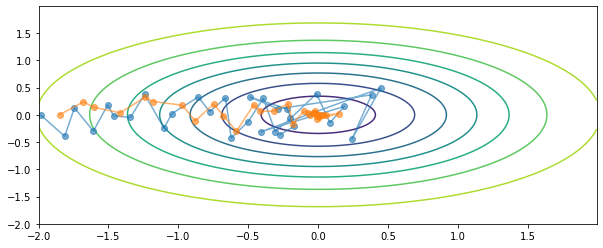

In [7]:
fig, ax = plt.subplots(figsize=(10, 4))
x, y = np.mgrid[-2:2:.01, -2:2:.01]
pos = np.dstack((x, y))
rv = multivariate_normal([0, 0], [[1, .05], [0, .7]])
ax.contour(x, y, -rv.pdf(pos))

epochs = 20
x = np.linspace(-2, 0, epochs)
ax.plot(np.r_[x+(np.random.rand(epochs)*.1), np.random.rand(10)-.5], np.r_[np.random.rand(epochs)-.5, np.random.rand(10)-.5], alpha=.6, marker='o')
ax.plot(np.r_[x+(np.random.rand(epochs)*.1), np.random.rand(10)-.5]*np.arange(0, epochs+10)[::-1]/(epochs+10), 
        np.r_[np.random.rand(epochs)-.5, np.random.rand(10)-.5]*np.arange(epochs+10)[::-1]/(epochs+10), alpha=.6, marker='o');

<i id="fig:lrdecay">A bidimensional feature space with contours of iso-values of the cost $J$ with gradient descent steps taken with constant learning rate (blue) and decaying learning rate (orange).</i>

In learning rate decay, our learning rate $\alpha$ becomes smaller each epoch, according to a system. There are different systems, among the most common way of computing $\alpha$ we have

$$
\begin{aligned}
& \alpha = \frac{1}{1+d \cdot \tau} \alpha_0 \\
& \\
& \alpha = 0.95^\tau \cdot \alpha_0 \\
& \\
& \alpha = \frac{k}{\sqrt{\tau}} \cdot \alpha_0 \\
& \\
& \alpha = \frac{k}{\sqrt{t}} \cdot \alpha_0 \\
\end{aligned}
$$

where $k$ is a constant, $t$ is the mini-batch number and $\tau$ is the epoch-number.

Sometimes instead **manual decay** is applied. This means that while the algorithm is training, you can evaluate the the learning rate needs to be tuned down and setting it manually.